## A closer look at QMCPy's Sobol' generator

In [1]:
from qmcpy import *
from numpy import *
from matplotlib import pyplot
from time import time
import os

### Basic usage

In [2]:
s = DigitalNetB2(5,seed=7)
s

DigitalNetB2 (DiscreteDistribution Object)
    d               5
    dvec            [0 1 2 3 4]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()

In [3]:
s.gen_samples(4) # generate Sobol' samples

array([[0.001195  , 0.36805613, 0.91941469, 0.29398509, 0.2678624 ],
       [0.5670506 , 0.7528246 , 0.4120121 , 0.68123844, 0.85543858],
       [0.26731079, 0.66382317, 0.1428683 , 0.81165271, 0.0161068 ],
       [0.83218482, 0.21657762, 0.6511894 , 0.16771364, 0.60332059]])

In [4]:
s.gen_samples(n_min=2,n_max=4) # generate from specific range. If range is not powers of 2, use graycode

array([[0.26731079, 0.66382317, 0.1428683 , 0.81165271, 0.0161068 ],
       [0.83218482, 0.21657762, 0.6511894 , 0.16771364, 0.60332059]])

In [5]:
t0 = time()
s.gen_samples(2**25)
print('Time: %.2f'%(time()-t0))

array([[0.001195  , 0.36805613, 0.91941469, 0.29398509, 0.2678624 ],
       [0.5670506 , 0.7528246 , 0.4120121 , 0.68123844, 0.85543858],
       [0.26731079, 0.66382317, 0.1428683 , 0.81165271, 0.0161068 ],
       ...,
       [0.67788522, 0.21152965, 0.6511978 , 0.98436408, 0.25071964],
       [0.47188771, 0.37279528, 0.91941056, 0.60282257, 0.62034225],
       [0.91274695, 0.75754471, 0.41200451, 0.49788924, 0.00247356]])

Time: 1.59


### Randomize with digital shift / linear matrix scramble

In [6]:
s = DigitalNetB2(2,randomize='LMS_DS') # linear matrix scramble with digital shift (default)
s.gen_samples(2)

array([[0.88410917, 0.51707422],
       [0.11787879, 0.38520767]])

In [7]:
s = DigitalNetB2(2,randomize='LMS') # just linear matrix scrambling
s.gen_samples(2, warn=False) # suppress warning that the first point is still the origin

array([[0.        , 0.        ],
       [0.8556844 , 0.73201977]])

In [8]:
s = DigitalNetB2(2,randomize='DS') # just digital shift
s.gen_samples(2)

array([[0.48252472, 0.34055396],
       [0.98252472, 0.84055396]])

### Support for graycode and natural ordering

In [9]:
s = DigitalNetB2(2,randomize=False,graycode=False)
s.gen_samples(n_min=4,n_max=8,warn=False) # don't warn about non-randomized samples including the origin

array([[0.125, 0.625],
       [0.625, 0.125],
       [0.375, 0.375],
       [0.875, 0.875]])

In [10]:
s = DigitalNetB2(2,randomize=False,graycode=True)
s.gen_samples(n_min=4,n_max=8,warn=False)

array([[0.375, 0.375],
       [0.875, 0.875],
       [0.625, 0.125],
       [0.125, 0.625]])

## Custom Dimensions

In [11]:
s = DigitalNetB2(3,randomize=False)
s.gen_samples(n_min=4,n_max=8)

array([[0.125, 0.625, 0.375],
       [0.625, 0.125, 0.875],
       [0.375, 0.375, 0.625],
       [0.875, 0.875, 0.125]])

In [12]:
s = DigitalNetB2([1,2],randomize=False) # use only the second and third dimensions in the sequence
s.gen_samples(n_min=4,n_max=8)

array([[0.625, 0.375],
       [0.125, 0.875],
       [0.375, 0.625],
       [0.875, 0.125]])

### Custom generating matrices

In [13]:
# a previously created generating matrix (not the default)
basedir = os.path.dirname(os.path.dirname(os.path.abspath('')))
filepath = os.path.join(basedir, 'qmcpy', 'discrete_distribution', 'digital_net_b2', 'generating_matrices', 'sobol_mat.51.30.30.msb.npy') if 'QMCSoftware' in basedir else  os.path.join(basedir, 'QMCSoftware', 'qmcpy', 'discrete_distribution', 'digital_net_b2', 'generating_matrices', 'sobol_mat.51.30.30.msb.npy')
z = load(filepath)
# max dimension 51, max samples 2^30, most significant bit in top of column
print(z.dtype)
z[:2,:2]

int64


array([[536870912, 805306368],
       [536870912, 268435456]])

In [14]:
z_custom = z[:10,:] # say this is our custom generating matrix. Make sure the datatype is numpy.int64
d_max,m_max = z_custom.shape
t_max = log2(z[0,0])+1 # number of bits in the first integer
f_path = 'my_sobol_mat.%d.%d.%d.msb.npy'%(d_max,t_max,m_max)
print(f_path)
save(f_path, z_custom)# save it to a file with proper naming convention
s = DigitalNetB2(3,generating_matrices=f_path) # plug in the path
print(s.gen_samples(4))
os.remove(f_path)

my_sobol_mat.10.30.30.msb.npy
[[0.92292163 0.24908136 0.81082754]
 [0.04743336 0.88896569 0.1326824 ]
 [0.33221532 0.26657102 0.45262145]
 [0.70868016 0.5954202  0.61614813]]


# Elementary intervals

In [15]:
def plt_ei(x,ax,x_cuts,y_cuts):
    for ix in arange(1,x_cuts,dtype=float): ax.axvline(x=ix/x_cuts,color='r',alpha=.5)
    for iy in arange(1,y_cuts,dtype=float): ax.axhline(y=iy/y_cuts,color='r',alpha=.5)
    ax.scatter(x[:,0],x[:,1],color='b',s=25)
    ax.set_xlim([0,1])
    ax.set_xticks([0,1])
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    ax.set_aspect(1)

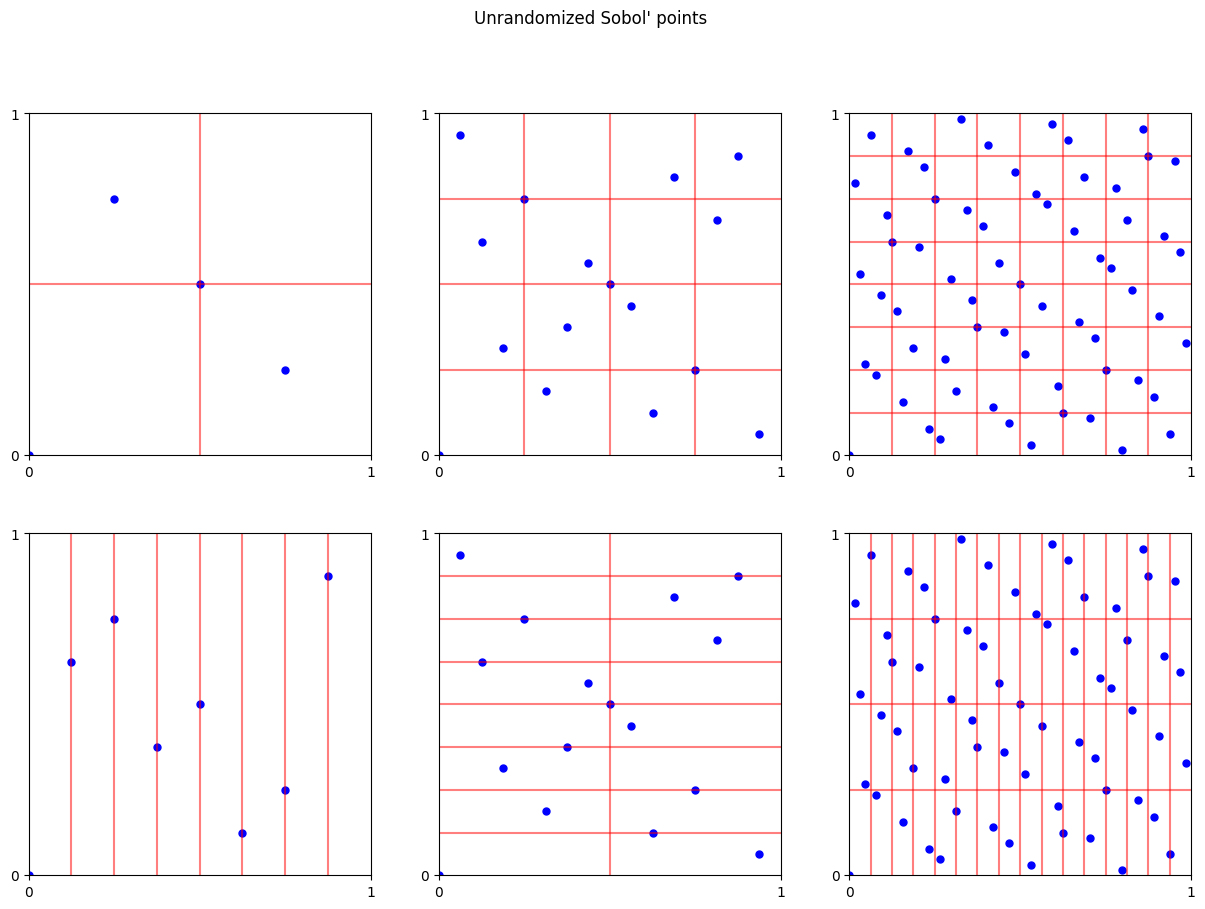

In [16]:
# unrandomized 
fig,ax = pyplot.subplots(ncols=3,nrows=2,figsize=(15,10))
s = DigitalNetB2(2,randomize=False)
plt_ei(s.gen_samples(2**2,warn=False),ax[0,0],2,2)
plt_ei(s.gen_samples(2**3,warn=False),ax[1,0],8,0)
plt_ei(s.gen_samples(2**4,warn=False),ax[0,1],4,4)
plt_ei(s.gen_samples(2**4,warn=False),ax[1,1],2,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[0,2],8,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[1,2],16,4)
fig.suptitle("Unrandomized Sobol' points");

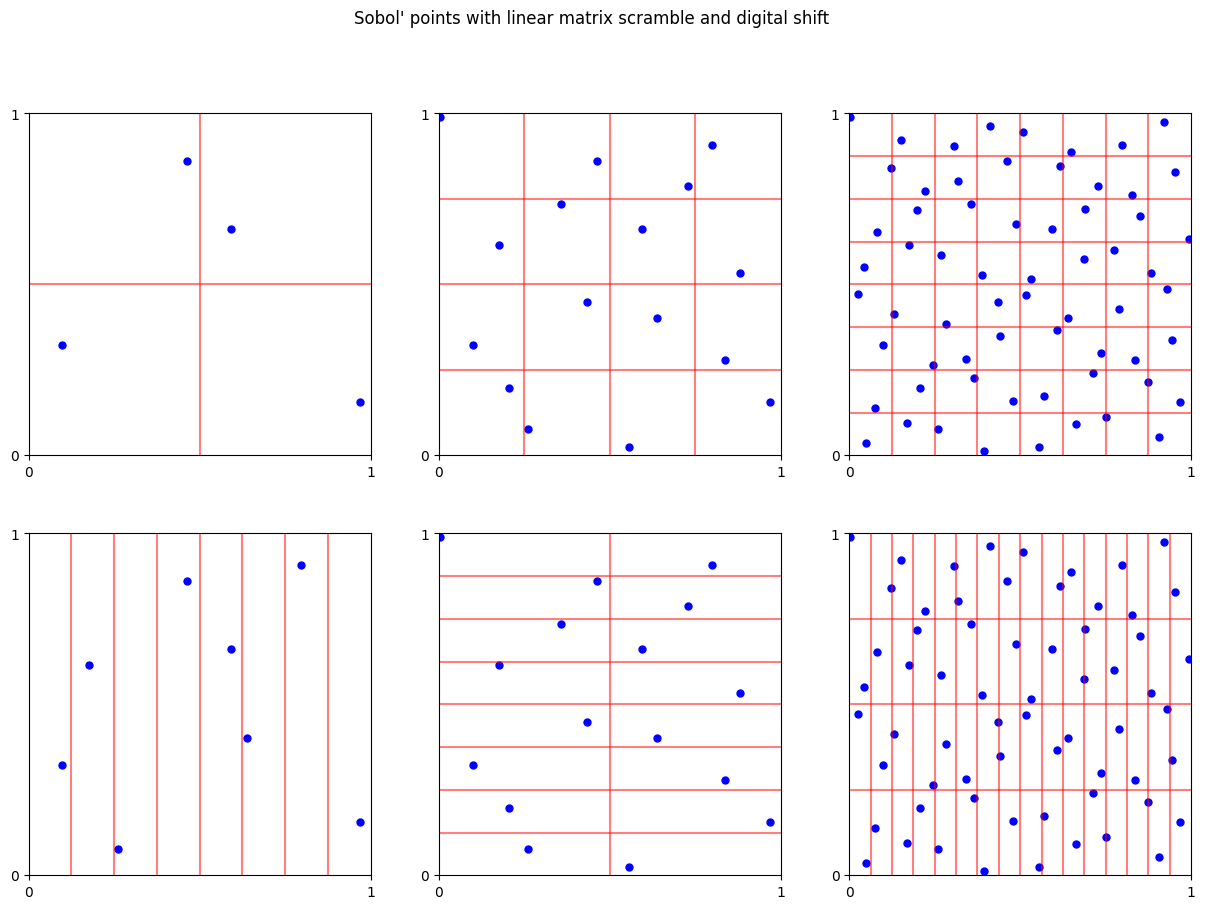

In [17]:
fig,ax = pyplot.subplots(ncols=3,nrows=2,figsize=(15,10))
s = DigitalNetB2(2,randomize='LMS_DS')
plt_ei(s.gen_samples(2**2,warn=False),ax[0,0],2,2)
plt_ei(s.gen_samples(2**3,warn=False),ax[1,0],8,0)
plt_ei(s.gen_samples(2**4,warn=False),ax[0,1],4,4)
plt_ei(s.gen_samples(2**4,warn=False),ax[1,1],2,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[0,2],8,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[1,2],16,4)
fig.suptitle("Sobol' points with linear matrix scramble and digital shift");

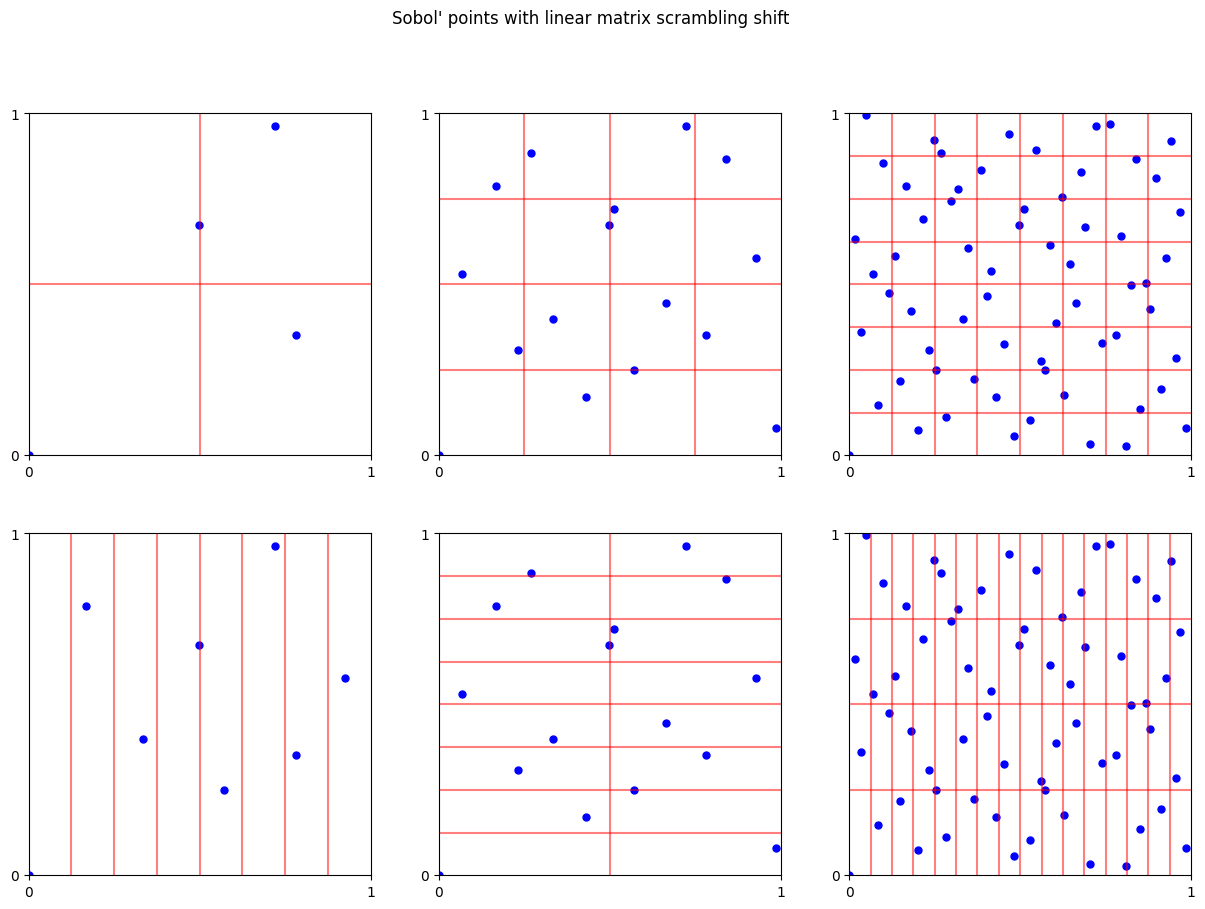

In [18]:
fig,ax = pyplot.subplots(ncols=3,nrows=2,figsize=(15,10))
s = DigitalNetB2(2,graycode=True,randomize='LMS')
plt_ei(s.gen_samples(2**2,warn=False),ax[0,0],2,2)
plt_ei(s.gen_samples(2**3,warn=False),ax[1,0],8,0)
plt_ei(s.gen_samples(2**4,warn=False),ax[0,1],4,4)
plt_ei(s.gen_samples(2**4,warn=False),ax[1,1],2,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[0,2],8,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[1,2],16,4)
fig.suptitle("Sobol' points with linear matrix scrambling shift");

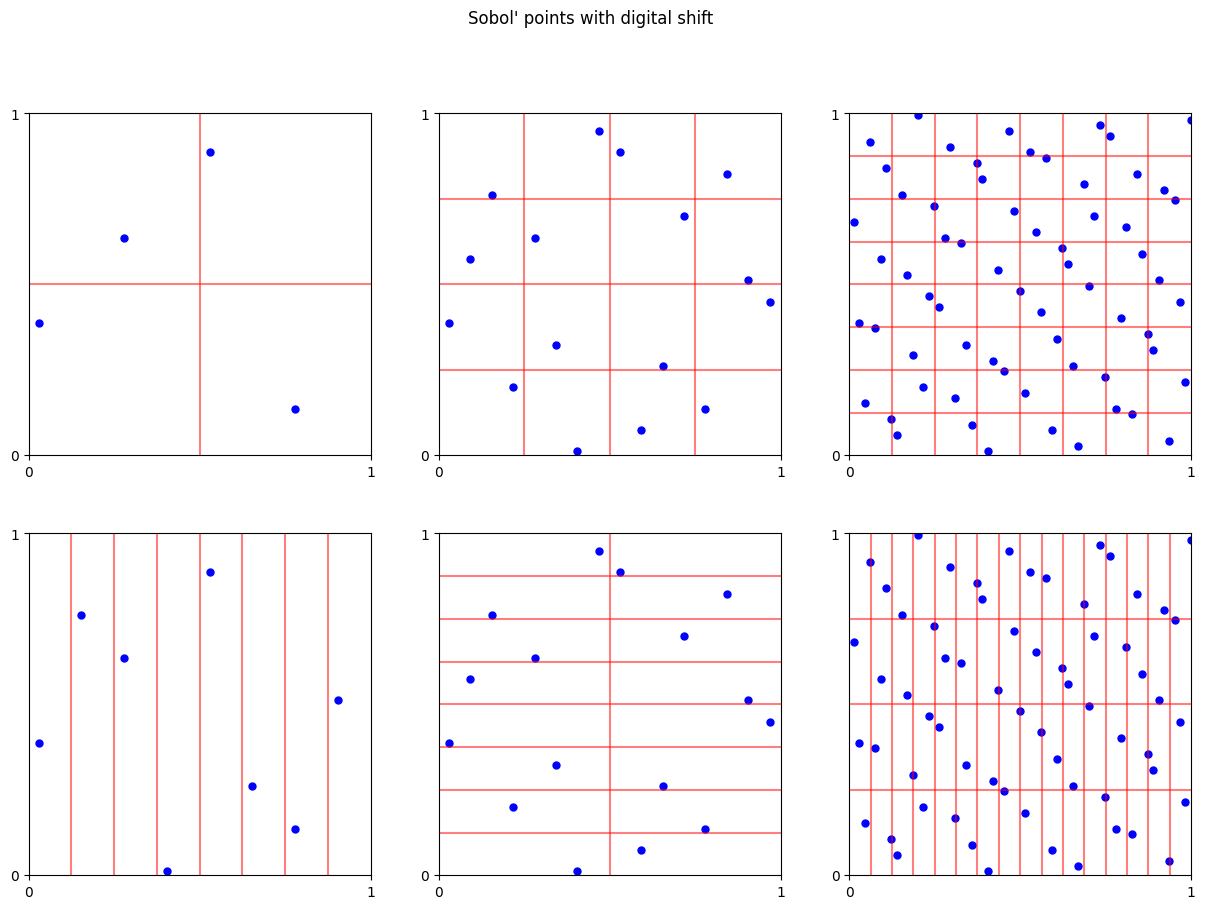

In [19]:
fig,ax = pyplot.subplots(ncols=3,nrows=2,figsize=(15,10))
s = DigitalNetB2(2,graycode=True,randomize='DS')
plt_ei(s.gen_samples(2**2,warn=False),ax[0,0],2,2)
plt_ei(s.gen_samples(2**3,warn=False),ax[1,0],8,0)
plt_ei(s.gen_samples(2**4,warn=False),ax[0,1],4,4)
plt_ei(s.gen_samples(2**4,warn=False),ax[1,1],2,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[0,2],8,8)
plt_ei(s.gen_samples(2**6,warn=False),ax[1,2],16,4)
fig.suptitle("Sobol' points with digital shift");

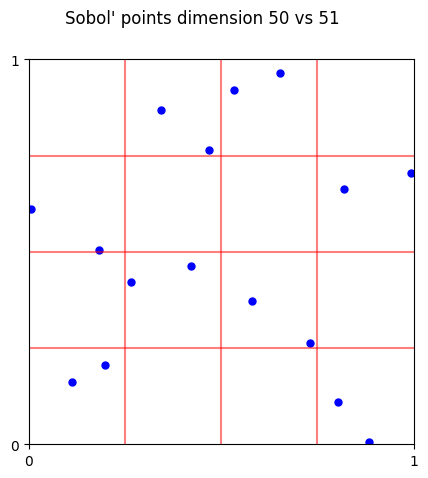

In [20]:
fig,ax = pyplot.subplots(figsize=(15,5))
s = DigitalNetB2([50,51],randomize='LMS_DS')
plt_ei(s.gen_samples(2**4),ax,4,4)
fig.suptitle("Sobol' points dimension 50 vs 51");
# nice properties do not necessary hold in higher dimensions

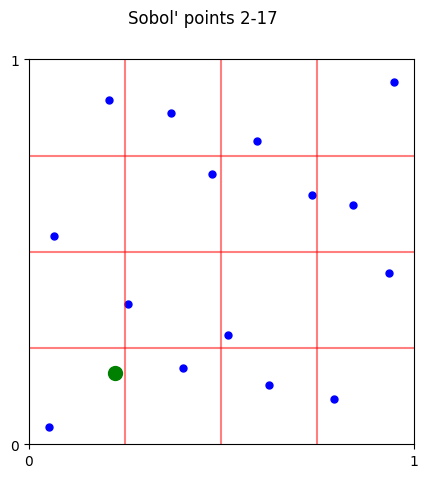

In [21]:
fig,ax = pyplot.subplots(figsize=(15,5))
s = DigitalNetB2(2,randomize='LMS_DS',graycode=True)
plt_ei(s.gen_samples(n_min=1,n_max=16),ax,4,4)
x16 = s.gen_samples(n_min=16,n_max=17)
ax.scatter(x16[:,0],x16[:,1],color='g',s=100)
fig.suptitle("Sobol' points 2-17");
# better to take points 1-16 instead of 2-16

### Skipping points vs. randomization

The first point in a Sobol' sequence is $\vec{0}$. Therefore, some software packages skip this point as various transformations will map 0 to NAN. For example, the inverse CDF of a Gaussian density at $\vec{0}$ is $-\infty$. However, we argue that it is better to randomize points than to simply skip the first point for the following reasons:

1. Skipping the first point does not give the uniformity advantages when taking powers of 2. For example, notice the green point in the above plot of "Sobol' points 2-17".
2. Randomizing Sobol' points will return 0 with probability 0.

A more thorough explanation can be found in Art Owen's paper [On dropping the first Sobol' point](https://arxiv.org/abs/2008.08051)

So always randomize your Sobol' unless you specifically need unrandomized points. In QMCPy the Sobol' generator defaults to randomization with a linear matrix scramble.

The below code runs tests comparing unrandomized vs. randomization with linear matrix scramble with digital shift vs. randomization with just digital shift. Furthermore, we compare taking the first $2^n$ points vs. dropping the first point and taking $2^n$ points vs. dropping the first point and taking $2^n-1$ points.

The 2D keister function is used for testing purposes as it can be exactly integrated using Mathematica:\
`N[Integrate[E^(-x1^2 - x2^2) Cos[Sqrt[x1^2 + x2^2]], {x1, -Infinity, Infinity}, {x2, -Infinity, Infinity}]]`

Plots the median (line) and fills the middle 10% of observations

In [22]:
def plt_k2d_sobol(ax,rtype,colors,plts=[1,2,3]):
    trials = 100
    solution = 1.808186429263620
    ms = arange(10,18)
    ax.set_xscale('log',base=2);
    ax.set_yscale('log',base=10);
    epsilons = {}
    if 1 in plts:
        epsilons['$2^m$ points with skipped $1^{st}$ point'] = zeros((trials,len(ms)),dtype=double)
    if 2 in plts:
        epsilons['$2^m-1$ points with skipped $1^{st}$ point'] = zeros((trials,len(ms)),dtype=double)
    if 3 in plts:
        epsilons['$2^n$ points no skipping'] = zeros((trials,len(ms)),dtype=double)
    for i,m in enumerate(ms):
        for t in range(trials):
            s = DigitalNetB2(2,randomize=rtype,graycode=True)
            k = Keister(s)
            if 1 in plts:
                epsilons['$2^m$ points with skipped $1^{st}$ point'][t,i] = \
                     abs(k.f(s.gen_samples(n_min=1,n_max=1+2**m)).mean()-solution)
            if 2 in plts:
                epsilons['$2^m-1$ points with skipped $1^{st}$ point'][t,i] = \
                     abs(k.f(s.gen_samples(n_min=1,n_max=2**m)).mean()-solution)
            if 3 in plts:
                epsilons['$2^n$ points no skipping'][t,i] = \
                     abs(k.f(s.gen_samples(n=2**m)).mean()-solution)
    for i,(label,eps) in enumerate(epsilons.items()):
        bot = percentile(eps, 40, axis=0)
        med = percentile(eps, 50, axis=0)
        top = percentile(eps, 60, axis=0)
        ax.loglog(2**ms,med,label=label+' with %s randomization'%rtype,color=colors[i]);
        ax.fill_between(2**ms, bot, top, color=colors[i], alpha=.3); 

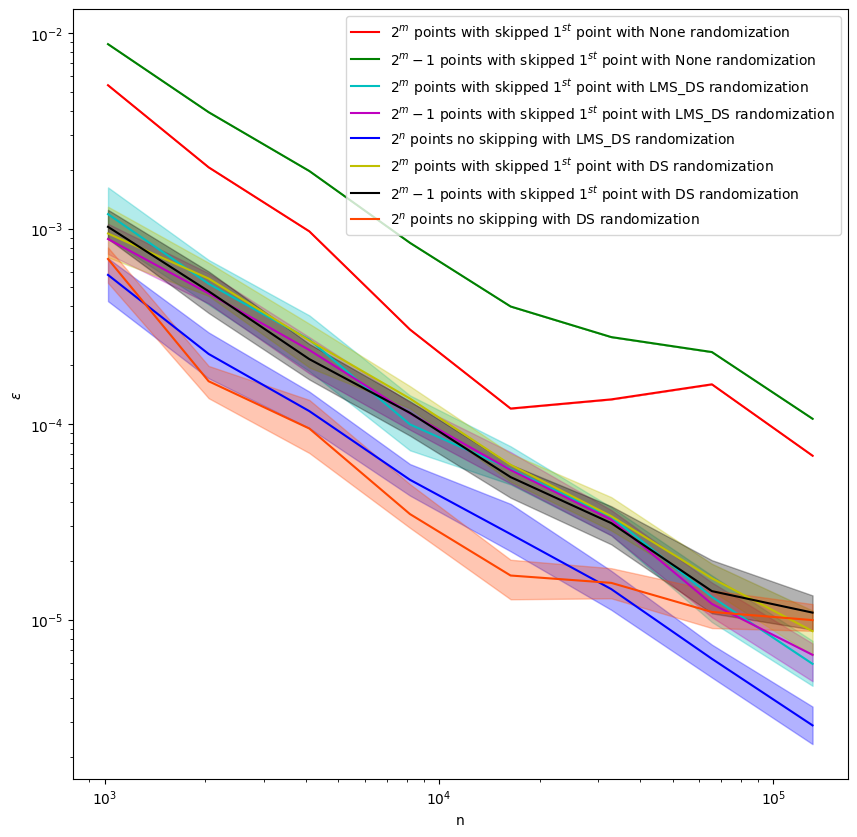

In [23]:
# compare randomization fig,ax = pyplot.subplots(figsize=(10,10))
fig,ax = pyplot.subplots(figsize=(10,10));
plt_k2d_sobol(ax,None,['r','g'],[1,2])
plt_k2d_sobol(ax,'LMS_DS',['c','m','b'],[1,2,3])
plt_k2d_sobol(ax,'DS',['y','k','orangered'],[1,2,3])
ax.legend();
ax.set_xlabel('n');
ax.set_ylabel('$\\epsilon$');